# An example of a model for predicting the author of the paintings

This notebook demonstrates how to use the use of transfer learning to quickly and efficiently get a model to predict the author of a picture according to its style.

For training, a manually prepared dataset was used, which I am not yet ready to give to the public. If you want to repeat my result, then you can contact me specifying the reason why you need this dataset. Anyway, the [weight](https://mega.nz/#!M9hRWAia!u0zQatxynW5VJA3IkNsLgPKflW_OU37R6u-aGrqu4nw) of the model in the public domain, which you can use for any purpose.

## Preparation

For a start, we will perform all the necessary imports. This project uses the fastai library. If you already have this library installed, do not run the next cell.

In [0]:
!pip install fastai

Unpacking archive with dataset. The file structure is as follows:

*   data
**   paintings
** * Directories named respectively by the authors of the works
** * * picures
** * models
** * * Result of saving and exporting models

In [0]:
!tar xzf paintings.tar.gz

In [0]:
from fastai.vision import verify_images, ImageDataBunch, get_transforms, \
    imagenet_stats, np, cnn_learner, models, error_rate,  \
    ClassificationInterpretation, open_image
from IPython.display import Image, display
from random import choice
from io import BytesIO
import os
import requests

## Dataset

This dataset includes photographs of paintings by Arkhip Ivanovich Kuindzhi, Isaac Ilyich Levitan, Ivan Ivanovich Shishkin, Michelangelo Merisi da Caravaggio and Salvador Dali. The first three authors worked in a relatively identical style, so if you are not an expert, then it will not be easy for you to understand exactly who created the picture. The last two authors, on the contrary, have a well-recognized style (relative to this dataset). I wondered how well modern algorithms of machine learning can cope with this task in such conditions.

Let's check if all images open correctly, etc.

In [5]:
path = 'data/paintings'
classes = ['Kuinji', 'Levitan', 'Shishkin', 'caravaggio', 'salvador_dali']

for c in classes:
    print(c)
    verify_images(path + '/' + c, delete=True, max_size=500)

Kuinji


Levitan


Shishkin


caravaggio


salvador_dali


All OK. Split into a training and validation sample. We perform augmentation and normalize values in dataset. [Mean and std are used for pre-trained networks.](https://pytorch.org/docs/stable/torchvision/models.html)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Let's take a look at our dataset.

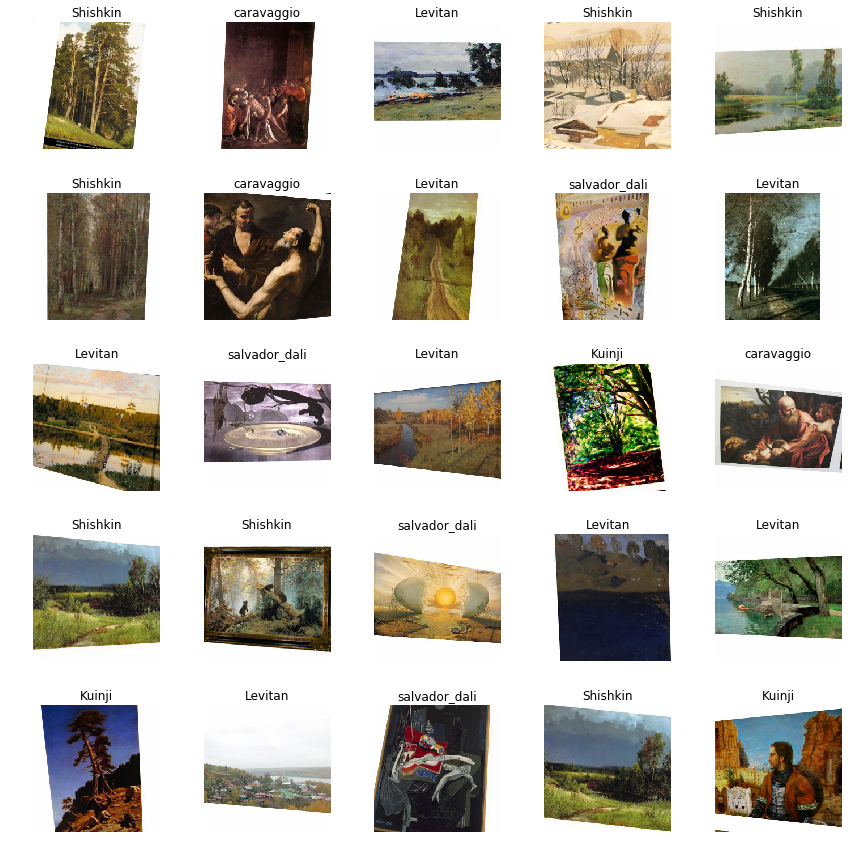

In [12]:
data.show_batch(rows=5, figsize=(12,12))

And raw data.

Kuinji


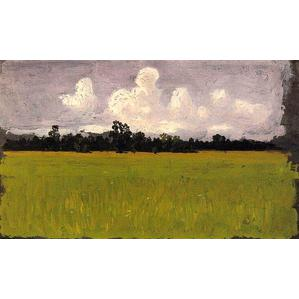

Levitan


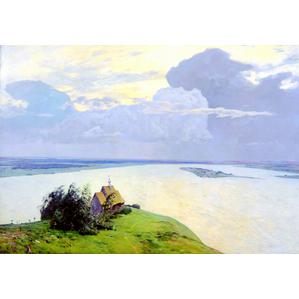

Shishkin


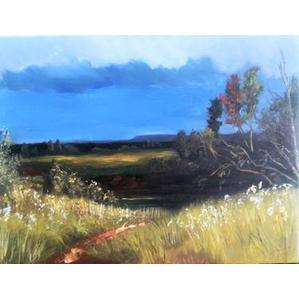

caravaggio


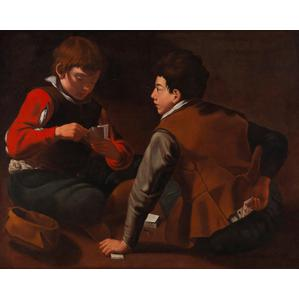

salvador_dali


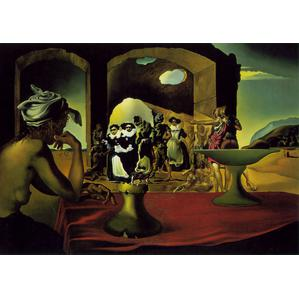

In [33]:
for c in data.classes:
    print(c)
    class_path = os.path.join(path, c)
    img = choice(os.listdir(class_path))
    display(Image(os.path.join(class_path, img)))

## Training

I decided to use the resnet architecture, because at present it shows the most qualitative results in classification tasks. For my relatively small sample of pictures, resnet34 is quite enough. I think it would be possible to use resnet18, but it showed a slightly worse result.

In [38]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 94697555.16it/s]


For warm-up we will train only the last fully connected layers. For the most efficient use of computational resources, I will use the[ policy of cyclic change of the step gradient descent](https://arxiv.org/pdf/1506.01186.pdf) (aka one cycle policy).

In [39]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.210000,0.650305,0.215589,00:21
1,0.798509,0.489497,0.179104,00:21
2,0.628652,0.428033,0.152570,00:22
3,0.510122,0.410217,0.139303,00:24


Not bad. The number of errors is less than 14%, and it takes only one and a half minutes. Save the result.

Is it possible to improve the result if you train the whole model?

In [0]:
learn.save('/r34-ap-s1')

Let's try to find the optimal range for the gradient step.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


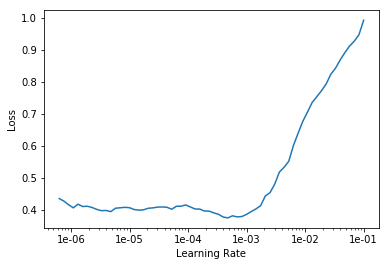

In [41]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(20, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.416458,0.401771,0.135987,00:23
1,0.405887,0.387415,0.134328,00:23
2,0.368938,0.342025,0.104478,00:22
3,0.333617,0.320817,0.099502,00:22
4,0.288515,0.298304,0.092869,00:24
5,0.244215,0.284663,0.087894,00:22
6,0.189507,0.293912,0.094527,00:23
7,0.153180,0.285554,0.096186,00:23
8,0.115413,0.289542,0.086235,00:24
9,0.097115,0.288500,0.091211,00:23


Great! Now the error does not exceed 7%.

In [0]:
learn.save('/r34-ap-s2')

## Interpritation

Let's see where the network is wrong most often.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

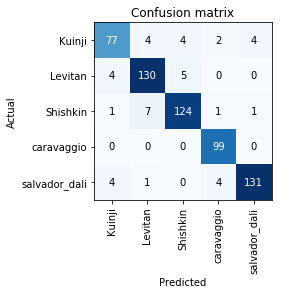

In [46]:
interp.plot_confusion_matrix()

As expected, it is most difficult to distinguish the works of Shishkin, Levaitan and Kuindzhi from each other. Nevertheless, if you look at examples of errors with thermal maps imposed on them, it becomes obvious that the result can be improved if you prepare the data more thoroughly. White fields at the top and bottom of the picture simply confuse the neural network. However, I suppose that in this way it will turn out to improve the result by less than one percent, so for the time being I have decided to stop there.

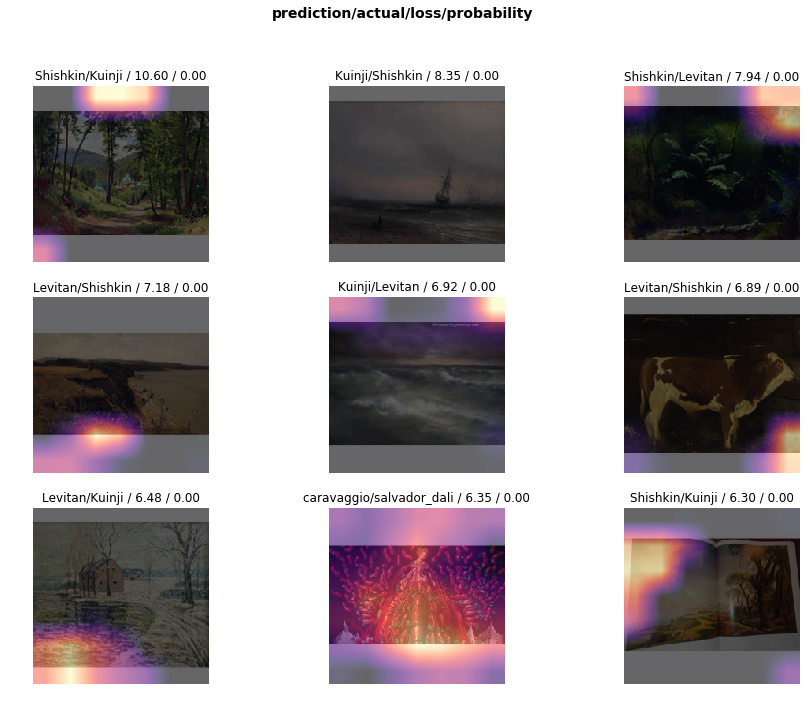

In [47]:
interp.plot_top_losses(9, figsize=(15,11))

### Testing

Let's try to predict the author of the picture from dataset.

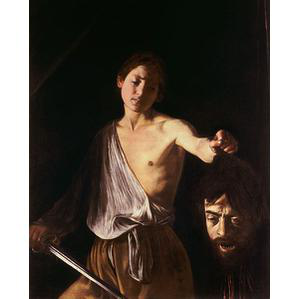

In [50]:
img = open_image(path + '/caravaggio/000001.jpg')
img

In [51]:
pred_class, _, _ = learn.predict(img)
print(pred_class)

caravaggio


That's right, no surprises. Now let's try something more complicated. For example, a photo where in addition to the paintings there are many foreign objects.

In [0]:
def predict_from_url(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    img.show(figsize=(10, 5))
    pred_class, pred_idx, outputs = learn.predict(img)
    return (pred_class, pred_idx, outputs)

And it works!

(Category caravaggio,
 tensor(3),
 tensor([5.7910e-04, 4.7850e-05, 4.7776e-02, 9.4898e-01, 2.6160e-03]))

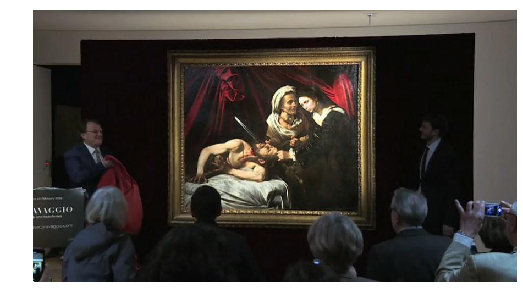

In [60]:
predict_from_url('https://static.euronews.com/articles/stories/03/69/66/04/880x495_cmsv2_e8f7a8f4-10e8-55b6-a22d-de9b8ea0fae6-3696604.jpg')